In [130]:
# Pychess imports
import chess
import chess.svg
import chess.engine
import asyncio
from chess.engine import Cp, Mate, MateGiven

import numpy as np
from numba import njit
import random

colab = False
if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.insert(0,'/content/drive/MyDrive/RL-projekt')
    path = "/content/drive/MyDrive/RL-projekt/"
else:
    path = ""
import sys
    

In [3]:
def evaluate_board(board):
    """Assigns a score to the board according to several metrics:
        - the value of the piece
        - the position of the piece
    
    Parameters
    ----------
    board : chess.Board
    """
    total_score = 0
    
    if board.is_checkmate():
        if board.turn == chess.WHITE:
            return -10000
        else: 
            return 10000
    
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            x = chess.square_file(square) # Letter - column
            y = chess.square_rank(square) # Number - row
    
            value = piece_value[piece.piece_type] + \
                    position_value[piece.piece_type][piece.color][y][x]
            
            # invert sign if black
            if piece.color == chess.BLACK: value = - value
                
            total_score += value   
            
    return total_score


""" ----------------------------------------------------------------------
    Positional and Piece Values
    ----------------------------------------------------------------------"""
piece_value = {
    chess.PAWN  : 10, 
    chess.BISHOP: 30, 
    chess.KNIGHT: 30, 
    chess.ROOK  : 40, 
    chess.QUEEN : 90, 
    chess.KING  : 1000
    }

black_pawn_eval = np.array([
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
    [5.0,  5.0,  5.0,  5.0,  5.0,  5.0,  5.0,  5.0],
    [1.0,  1.0,  2.0,  3.0,  3.0,  2.0,  1.0,  1.0],
    [0.5,  0.5,  1.0,  2.5,  2.5,  1.0,  0.5,  0.5],
    [0.0,  0.0,  0.0,  2.0,  2.0,  0.0,  0.0,  0.0],
    [0.5, -0.5, -1.0,  0.0,  0.0, -1.0, -0.5,  0.5],
    [0.5,  1.0, 1.0,  -2.0, -2.0,  1.0,  1.0,  0.5],
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0]
])

black_rook_eval = np.array([
    [  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
    [  0.5,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  0.5],
    [ -0.5,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -0.5],
    [ -0.5,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -0.5],
    [ -0.5,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -0.5],
    [ -0.5,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -0.5],
    [ -0.5,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -0.5],
    [  0.0,   0.0, 0.0,  0.5,  0.5,  0.0,  0.0,  0.0]
])

black_bishop_eval = np.array([
    [ -2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0],
    [ -1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -1.0],
    [ -1.0,  0.0,  0.5,  1.0,  1.0,  0.5,  0.0, -1.0],
    [ -1.0,  0.5,  0.5,  1.0,  1.0,  0.5,  0.5, -1.0],
    [ -1.0,  0.0,  1.0,  1.0,  1.0,  1.0,  0.0, -1.0],
    [ -1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0, -1.0],
    [ -1.0,  0.5,  0.0,  0.0,  0.0,  0.0,  0.5, -1.0],
    [ -2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0]
])

knight_eval = np.array([
    [-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0],
    [-4.0, -2.0,  0.0,  0.0,  0.0,  0.0, -2.0, -4.0],
    [-3.0,  0.0,  1.0,  1.5,  1.5,  1.0,  0.0, -3.0],
    [-3.0,  0.5,  1.5,  2.0,  2.0,  1.5,  0.5, -3.0],
    [-3.0,  0.0,  1.5,  2.0,  2.0,  1.5,  0.0, -3.0],
    [-3.0,  0.5,  1.0,  1.5,  1.5,  1.0,  0.5, -3.0],
    [-4.0, -2.0,  0.0,  0.5,  0.5,  0.0, -2.0, -4.0],
    [-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0]
])

black_king_eval = np.array([
    [ -3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
    [ -3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
    [ -3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
    [ -3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
    [ -2.0, -3.0, -3.0, -4.0, -4.0, -3.0, -3.0, -2.0],
    [ -1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.0],
    [  2.0,  2.0,  0.0,  0.0,  0.0,  0.0,  2.0,  2.0 ],
    [  2.0,  3.0,  1.0,  0.0,  0.0,  1.0,  3.0,  2.0 ]
])

queen_eval = np.array([
    [ -2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0],
    [ -1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -1.0],
    [ -1.0,  0.0,  0.5,  0.5,  0.5,  0.5,  0.0, -1.0],
    [ -0.5,  0.0,  0.5,  0.5,  0.5,  0.5,  0.0, -0.5],
    [  0.0,  0.0,  0.5,  0.5,  0.5,  0.5,  0.0, -0.5],
    [ -1.0,  0.5,  0.5,  0.5,  0.5,  0.5,  0.0, -1.0],
    [ -1.0,  0.0,  0.5,  0.0,  0.0,  0.0,  0.0, -1.0],
    [ -2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0]
])

white_pawn_eval = np.flipud(np.fliplr(black_pawn_eval))
white_bishop_eval = np.flipud(np.fliplr(black_bishop_eval))
white_rook_eval = np.flipud(np.fliplr(black_rook_eval))
white_king_eval = np.flipud(np.fliplr(black_king_eval))

position_value = {
    chess.PAWN   : {chess.WHITE: white_pawn_eval, chess.BLACK: black_pawn_eval},
    chess.BISHOP : {chess.WHITE: white_bishop_eval, chess.BLACK: black_pawn_eval},
    chess.KNIGHT : {chess.WHITE: knight_eval, chess.BLACK: knight_eval},            # same for both
    chess.ROOK   : {chess.WHITE: white_rook_eval, chess.BLACK: black_pawn_eval},
    chess.QUEEN  : {chess.WHITE: queen_eval, chess.BLACK: queen_eval},              # same for both
    chess.KING   : {chess.WHITE: white_king_eval, chess.BLACK: black_pawn_eval}
}

### Minimax algorithm
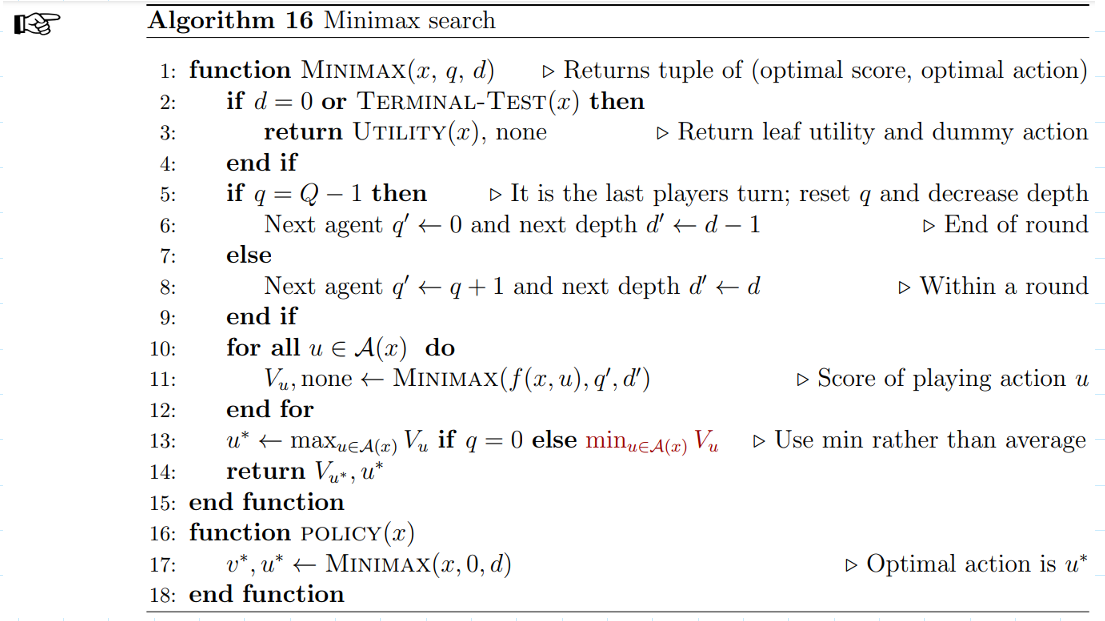

Let's suppose that we want to cheat while playing chess. We will enter all our opponent's move and the AI will choose the best move to take having considered all all posible states 3 moves ahead. (Be prepared to wait for long when setting the depth more than three!)

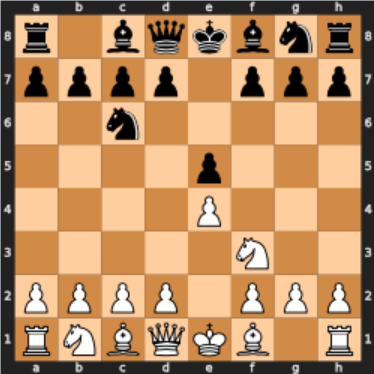

### Minimax with alpha beta pruning

In [121]:
from tqdm.notebook import tqdm

def pruning_minimax(board, depth, alpha=None, beta=None, to_move=None, stockfish_eval = False):
    """Minimax Tree evaluation improved by not considering positions 
    that can't affect the outcome.

    Parameters
    ----------
    board : chess.Board
        a chess board with a particular setup (pieces->squares)
    depth : int
        how many moves ahead we want to think
    alpha : int, optional
        highest value in the subtree, by default -np.infty
    beta : int, optional
        lowest value in the subtree, by default np.infty
    to_move : chess.Player, optional
        the player whose turn it is to make a move, by default None
    """
    if alpha is None : alpha = -np.infty
    if beta is None : beta = np.infty

    if depth == 0 or board.is_game_over():
        # static eval - end of recursion
        # asyncio.set_event_loop_policy(chess.engine.EventLoopPolicy())
        if stockfish_eval:
            return board.peek(), stockfish_evaluation(board)
        else:
            return board.peek(), evaluate_board(board)

    if to_move == chess.WHITE : # maximise
        
        max_val = -np.infty
        best_move = None

        # we should explore each tree branch
        for move in board.legal_moves:

            # simulate the move (explore the branch)
            board.push(move)

            # evaluate it
            _, value = pruning_minimax(board, depth-1, alpha, beta, to_move=chess.BLACK, stockfish_eval = stockfish_eval)

            # if best move seen, update it
            if value > max_val:
                best_move = move
                max_val = value
            
            # take it back (return to parent)
            board.pop()
            
            alpha = max(alpha, value)
            # no sense checking other options as the player is not
            # likely to choose this branch under the hypothesis
            # he performs the best move, otherwise if he does he 
            # will end in a situation worse for him
            if beta <= alpha: break 
        
        return best_move, max_val


    else : # black -> minimise

        min_val = np.infty
        best_move = None

        # we should explore the tree
        for move in board.legal_moves:

            # simulate the move (explore the branch)
            board.push(move)

            # evaluate it
            _, value = pruning_minimax(board, depth -1, alpha, beta, to_move=chess.WHITE, stockfish_eval = stockfish_eval)

            # if best move seen, update it
            if value < min_val:
                best_move = move
                min_val = value
            
            # take it back (return to parent)
            board.pop()
            
            beta = min(beta, value)
            # no sense checking other options as the player is not
            # likely to choose this branch under the hypothesis
            # he performs the best move, otherwise if he does he 
            # will end in a situation worse for him
            if beta <= alpha: break
            
        return best_move, min_val

In [139]:
def play_game(depth=3, init_fen=None, 
              interactivePlay = False, 
              stockfish_eval = False, 
              aginst_stockfish = False,
              random_baseline = False):
    engine = chess.engine.SimpleEngine.popen_uci(path + "stockfish_13_win_x64")
    #start a game with the default setup
    if init_fen is None: init_fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
    board = chess.Board(fen=init_fen)
    #chess.svg.board(board, size=250)
    states = []
    
    # if AIcolor == chess.BLACK: 
    #     print('Enter the opponent\'s move')
    #     opponent_move = input()
    #     board.push(chess.Move.from_uci(str(opponent_move)))
    #     states.append(board.fen())
    #     print(board)

    # print(board.result())

    while not board.is_game_over():
        
        # White move
        best_move, val = pruning_minimax(board, depth=depth, to_move=chess.WHITE, stockfish_eval = stockfish_eval)
        print(f'White plays: {best_move}  of approx. value: {val}')
        board.push(best_move)
        states.append(board.fen())
        print(board, "\n")
        
        if board.is_game_over(): 
            break
        
        #Play against you or another MiniMax agent
        if interactivePlay == True: 
            # Opponent move
            print('Enter the opponent\'s move')
            opponent_move = input()
            board.push(chess.Move.from_uci(str(opponent_move)))
            states.append(board.fen()) 
            print(board , "\n")
        elif aginst_stockfish == True:
            result = engine.play(board, chess.engine.Limit(time=0.1))
            board.push(result.move)
            print(f'Black plays: {result.move}  of approx. value: {stockfish_evaluation(board)}')
            print(board , "\n")
        elif random_baseline == True:
            move = random.choice([move for move in board.legal_moves])
            uci = move.uci()
            board.push_uci(uci)
            if stockfish_eval:
                val = stockfish_evaluation(board)
            else:
                val = evaluate_board(board)
            print(f'Black plays: {uci}  of approx. value: {val}')
            print(board , "\n")
        else:   
            # Black move
            best_move, val = pruning_minimax(board, depth=depth, to_move=chess.BLACK, stockfish_eval = stockfish_eval)
            print(f'Black plays: {best_move}  of approx. value: {val}')
            board.push(best_move)
            states.append(board.fen())
            print(board , "\n")

        if board.is_game_over():
            break
    
    print(f'Result:  White {board.result()} Black')
    engine.quit()
    return board.result()


#### Implementning the Stockfish Engine Evaluation

In [79]:
def stockfish_evaluation(board, time_limit = 0.01):
    engine = chess.engine.SimpleEngine.popen_uci(path + "stockfish_13_win_x64")
    result = engine.analyse(board, chess.engine.Limit(time=time_limit))
    if result['score'].is_mate():
        evaluation = result['score'].relative.score(mate_score = 10000)
    else:
        evaluation = result['score'].relative.score()
    engine.quit()
    return evaluation

### Play interactive game

In [140]:
states = play_game(depth=1, 
                   interactivePlay = False, 
                   stockfish_eval = False, 
                   aginst_stockfish = False,
                   random_baseline = True)

White plays: g1f3  of approx. value: 3.0
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R 

Black plays: c7c5  of approx. value: 4.0
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R 

White plays: b1c3  of approx. value: 9.0
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . . . . .
. . N . . N . .
P P P P P P P P
R . B Q K B . R 

Black plays: f7f5  of approx. value: 10.0
r n b q k b n r
p p . p p . p p
. . . . . . . .
. . p . . p . .
. . . . . . . .
. . N . . N . .
P P P P P P P P
R . B Q K B . R 

White plays: e2e4  of approx. value: 14.0
r n b q k b n r
p p . p p . p p
. . . . . . . .
. . p . . p . .
. . . . P . . .
. . N . . N . .
P P P P . P P P
R . B Q K B . R 

Black plays: c5c4  of approx. value: 13.0
r n b q k b n r
p p . p p . p p
. . . . . . . .
. . . . . p . .
. . p . P . . .
. . N . . N . .
P P P

#### Evaluate agains stockfish

In [141]:
%%capture
game_results = []
for i in tqdm(range(100)):
    game = play_game(depth=1, random_baseline = True)
    if game == '0-1':
        game_results.append(-1)
    elif game == '1/2-1/2':
        game_results.append(0)
    else:
        game_results.append(1)

In [145]:
# Performance rating:
games = len(game_results)
tot_op_ratings = 1000*games
wins = game_results.count(1)
losses = game_results.count(-1)

pr = (tot_op_ratings + 400 * (wins-losses))/games

print("We have achieved an elo of {0} over {1} games.".format(pr, games))

We have achieved an elo of 1332.0 over 100 games.


In [ ]:
#Opening book dowloaded from: https://sites.google.com/site/distributedchess/home/opening-book
#Nice guide to implementing opening books and evaluation: https://andreasstckl.medium.com/writing-a-chess-program-in-one-day-30daff4610ec
#Documentation on Polyglot: https://python-chess.readthedocs.io/en/latest/polyglot.html?highlight=polyglot
#Board evaluation using Stockfish engine: https://python-chess.readthedocs.io/en/latest/engine.html#analysing-and-evaluating-a-position

import chess
import chess.polyglot
OpeningBookPath = path + "the-generated-opening-book.bin"

#See a few moves from the opening book
board = chess.Board()

print(board , "\n")

move = chess.polyglot.MemoryMappedReader(OpeningBookPath).find(board).move()

board.push(move)

print(board, "\n")

move = chess.polyglot.MemoryMappedReader(OpeningBookPath).find(board).move()

board.push(move)

print(board, "\n")



r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R 

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. P . . . . . .
. . . . . . . .
P . P P P P P P
R N B Q K B N R 

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. P . . . . . .
. . . . . . . .
P . P P P P P P
R N B Q K B N R 

